### Multivariate state estimation technique

Моделирование системы в **$MSET$ использует данные, представляющие нормальные рабочие состояния системы** (данные без аномалий), и изучает взаимосвязи, существующие между переменными, используемыми для определения состояния. Иными словами, есть набор переменных которые описывают нормальное рабочее состояние системы. С помощью метода изучаются связи между такими переменными. Тогда при анализе данных с аномалиями эти связи могут быть нарушены, что и служит индикатором для обнаружения аномалий.

Собранные данные организуются в виде матрицы, где каждый вектор-столбец представляет измерения в момент времени $t_j$. Количество столбцов этой матрицы равно количеству наблюдений во времени, а количество строк равно количеству измеряемых показателей. Например, можно измерять давление, температуру и напряжение - это строки в матрице, тогда каждый столбец это состояние в конкретный момент времени.

<img src="mset_data.png" alt="Drawing" style="width: 400px; height: 200px"/>

В общем случае $x_{ji}$ - значение параметра $j$ в момент времени $i$. Тогда состояние в момент времени $X(t_i) = [x_{1i}, x_{2i} \ldots x_{ni}]^T$.

В процессе $MSET$ есть три ключевые процедуры (выполняются последовательно):
1. Выбор обучающих данных $T$ из матрицы $X_i(t_i)$.
2. Выбор данных для создания матрицы памяти $D$
3. Обучение и принятие решения

**Обучающие данные**. Определяются просто как $T \subset X_i(t_i)$, т.е. берется подмножество столбцов (состояний), при этом требуется чтобы данные не содержали аномалий и не нарушали целостность системы (это значит, что нельзя из момента времени выбросить один или несколько показателей). Размер подмножества $|T|$ определяется пользователем, скорее всего как гиперпараметр.

**Матрица памяти**. Определяется как подмножество $D \subset T$, при этом есть конструктивный алгоритм построения:
1. Состояния, которые содержат максимальные и минимальные значения характеристик системы, должны быть выбраны.
2. Из оставшихся данных выбираются состояния согласно алгоритму:
    * Упорядочиваем вектора на основе евклидовых норм
    * Добиваем до заданного вручную количества $|D|$ через равные интервалы
    * Оставшиеся состояния будут образовывать матрицу $L$

*Мое мнение, чем больше матрица памяти тем лучше*

Таким образом $T = D \cup L$. Весь процесс можно представить в виде блок-схемы:

<img src="mset_process.png" alt="Drawing" style="width: 700px; height: 200px"/>

Матрица $D$ характеризует нормальное рабочее состояние системы и играет ключевую роль. Именно под нее в процессе обучения выбираются веса по которым можно оценивать новые наблюдения.

**Обуение**. Итак, допустим мы построили матрицу памяти. Теперь нужно обучиться. Идея заключается просто во взвешивании, т.е. по сути решается задача регресии. Пусть $X_{obs}$ наблюдаемые новые состояния системы. Тогда $X_{est} = DW$, где $W$ - стобец весов. Ошибка обучения $\epsilon = X_{obs} - X_{est} = X_{obs} - DW$. Ясно, что $\epsilon \perp d_i$, где $d_i$ вектор-столбец из $D$. Почему это так? Рассмотрим задачу регресии как задачу проецирования из линейной алгберы.

Пусть у нас есть объекты $x \in R^n$, в качестве $n$ возьмем $3$, потому что это нагляднее, но на самом деле верно и для большего $n$. И пусть мы по двум измерениям (осям $X$ и $Y$) хотим предсказывать значение по оси $Z$. Окей, берем векторы в пространстве и просто проецируем на плоскость $XY$. В плоскости $XY$ есть базис, спроецированные векторы пространства можно единственным образом разложить по этому базису. Коэффициенты разложения по базису назовем весами. Тогда если вычесть из вектора в пространстве $XYZ$ его проекцию в $XY$, получим направляющий вектор плоскости $XY$. А значит любой вектор из плоскости, в том числе и базисный, перпендикулярен направляющему вектору. В этом примере базисные-вектора на плоскости это вектора матрицы $D$, направляющий вектор это $\epsilon$, а $X_{obs}$ это вектора в пространстве $XYZ$.

Поскольку $\epsilon \perp d_i$, то скалярное произведение $<\epsilon, d_i> = 0$, где $d_i$ вектор-столбец из матрицы $D$. Давайте рассмотрим скалярные произведение со всеми векторами из матрицы $D$, т.е. $<\epsilon, d_1> = <\epsilon, d_2> = \ldots = <\epsilon, d_{|D|}> = 0$. Это также можно записать в виде матричного умножения $D^T \epsilon = 0$. Подставим эпсилон и раскроем скобки, получается 
$$D^T(X_{obs} - DW) = 0$$
$$D^T X_{obs} = D^T D W$$
$$[D^TD]^{-1} [D^T X_{obs}] = W$$ при этом матрица $D^TD$ должна быть обратима

Иначе во второй строке обозначаем $D^TX_{obs} = B$, $D^TD = A$, $W = x$ и решаем СЛУ вида $Ax = B$

Таким образом находим вектор весов, тогда $X_{est} = D [D^TD]^{-1} [ D^T X_{obs}]$

Аналогично оцениваем остатки матрицы $L$, а затем легко вычисляем остатки $R_X = X_{est} - X_{obs}$ и $R_L = L_{est} - L_{obs}$

**Принятие решения**. Наша цель обнаружить аномалии, поэтому нужно оценить остатки на соответствие белому шуму. Это можно сделать, например, с помощью метода статистического принятия решений $SPRT$ [cool theory with example](https://www.weibull.com/hotwire/issue162/hottopics162.htm)

### Обнаружение аномалий на синтетических данных

Используется free-anomaly датасет, поскольку метод требует это для определения нормального рабочего состояния

In [256]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

df = pd.read_csv("data/other/3.csv", sep=";", index_col="datetime", parse_dates=True)
df.drop(["anomaly", "changepoint"], inplace=True, axis=1)
df.sort_index(inplace=True)

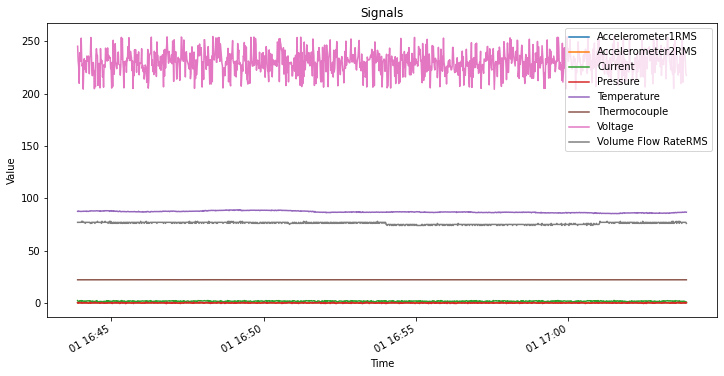

In [257]:
df.plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

#### Строим матрицу памяти $D$

1. Добавляем максимальные и минимальные характеристики по каждому измерению. То есть, например, все временные метки в которых максимальная/минимальная температура/давление/ток, и так далее по списку.

In [258]:
df_train = df[:400]
D = pd.DataFrame()

for column in df_train.columns:
    max_val = df_train[df_train[column] == df_train[column].max()][:1]
    D = pd.concat([D, max_val])

2. Теперь посчитаем норму для каждого вектора и добавим ее во фрейм

In [259]:
norms = []
for i in range(df_train.shape[0]):
    state = df_train.loc[df_train.index[i]]
    norm = np.linalg.norm(state)
    norms.append(norm)
    
df_train["Norm"] = norms
df_train.head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,Norm
datetime,,,,,,,,,
2020-03-01 16:43:54,0.080156,0.133327,2.189720,0.382638,87.5483,22.0839,245.320,76.9806,272.516576
2020-03-01 16:43:55,0.079986,0.137287,1.678980,-0.273216,87.8090,22.0847,231.669,77.0000,260.385481
2020-03-01 16:43:56,0.081473,0.131053,1.069850,-0.273216,87.4204,22.0849,226.153,77.0000,255.353660
2020-03-01 16:43:57,0.080830,0.131653,0.607355,0.382638,87.6346,22.0831,209.877,77.0000,241.133533
2020-03-01 16:43:58,0.080543,0.132672,2.027280,0.382638,87.5414,22.0831,239.048,77.0000,266.886468


3. Добиваем матрицу $D$ оставшимися значениями через фиксированный интервал. Размер матрицы $D$ задается пользователем.

  В случае ниже это $80\%$ от оставшихся данных после предыдущего шага

In [260]:
df_copy = df_train.copy()
df_copy.sort_values("Norm", inplace=True)
df_copy.drop(D.index, inplace=True)

sample = df_copy.sample(frac=0.9, random_state=1)
D = pd.concat([D, sample])

Матрица $D$ готова. Все, что не попало в нее, переходит в матрицу $L$.

In [261]:
L = df_copy.drop(sample.index)

In [262]:
D.shape[0] + L.shape[0] == df_train.shape[0]

True

Нормы больше не нужны, убираем.

In [263]:
D.drop(["Norm"], inplace=True, axis=1)
L.drop(["Norm"], inplace=True, axis=1)

In [264]:
D.sort_index(inplace=True)

In [265]:
SS = StandardScaler()
D = SS.fit_transform(D).T

#### Теперь будем оценивать аномалии

In [268]:
df_an = df[400:]
df_an.sort_index(inplace=True)

In [269]:
X_obs = SS.transform(np.array(df_an)).T

$X_{est} = D [D^TD]^{-1} [ D^T X_{obs}]$

In [271]:
def kernel(x,y):

    '''
    s(x,y) = 1 - ||x-y||/(||x|| + ||y||)
    '''

    if all(x==y):
        # Handling the case of x and y both being the zero vector.
        return 1.
    else:
        return 1. - np.linalg.norm(x-y)/(np.linalg.norm(x) + np.linalg.norm(y))

def otimes(X, Y):

    m1,n = np.shape(X)
    m2,p = np.shape(Y)

    if m1!=m2:
        raise Exception('dimensionality mismatch between X and Y.')

    Z = np.zeros( (n,p) )

    if n != p:
        for i in range(n):
            for j in range(p):
                Z[i,j] = kernel(X[:,i], Y[:,j])
    else:
        for i in range(n):     
            for j in range(i, p):
                Z[i,j] = kernel(X[:,i], Y[:,j])
                Z[j,i] = Z[i,j]

    return Z

In [272]:
a = otimes(np.array(D), np.array(D))

In [273]:
b = otimes(np.array(D), np.array(X_obs))

In [274]:
W = np.linalg.inv(a) @ b

In [301]:
X_est = np.array(D) @ W

In [302]:
r = np.array(X_obs) - np.array(D) @ W

In [303]:
X_est = SS.inverse_transform(X_est.T).T

In [323]:
rest = X_est - np.array(df_an.T)

In [168]:
df.columns

Index(['Accelerometer1RMS', 'Accelerometer2RMS', 'Current', 'Pressure',
       'Temperature', 'Thermocouple', 'Voltage', 'Volume Flow RateRMS',
       'Norm'],
      dtype='object')

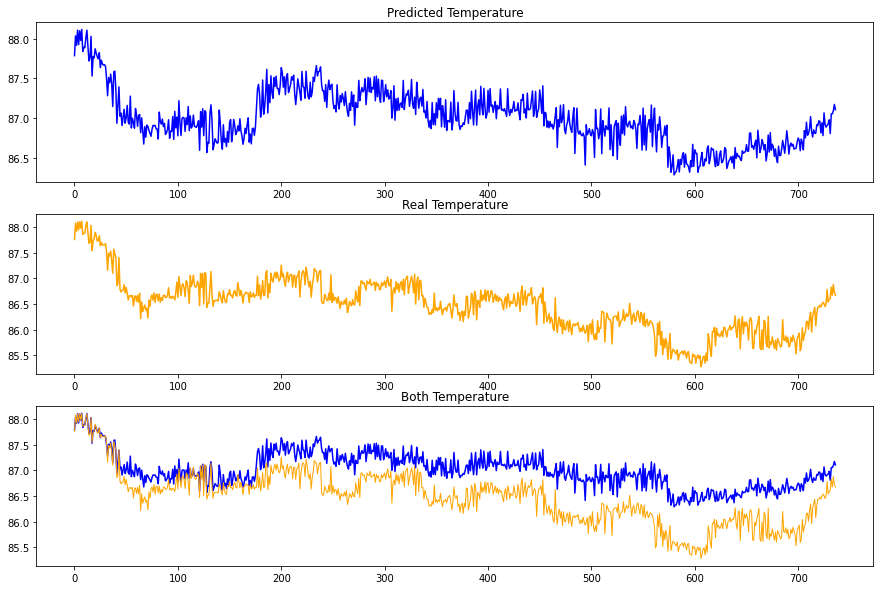

In [324]:
import matplotlib.pyplot as plt

i = 4 # Accelerometer1RMS

fig, axes = plt.subplots(3, 1, figsize=(15, 10))
axes[0].plot(X_est[i], color='blue')
axes[1].plot(np.array(df_an.T)[i], color='orange')

axes[2].plot(X_est[i], color='blue')
axes[2].plot(np.array(df_an.T)[i], color='orange', linewidth=1)

axes[0].set_title(f"Predicted {df.columns[i]}")
axes[1].set_title(f"Real {df.columns[i]}")
axes[2].set_title(f"Both {df.columns[i]}")

plt.show()

Графики остатков по каждой из характеристик выглядят так

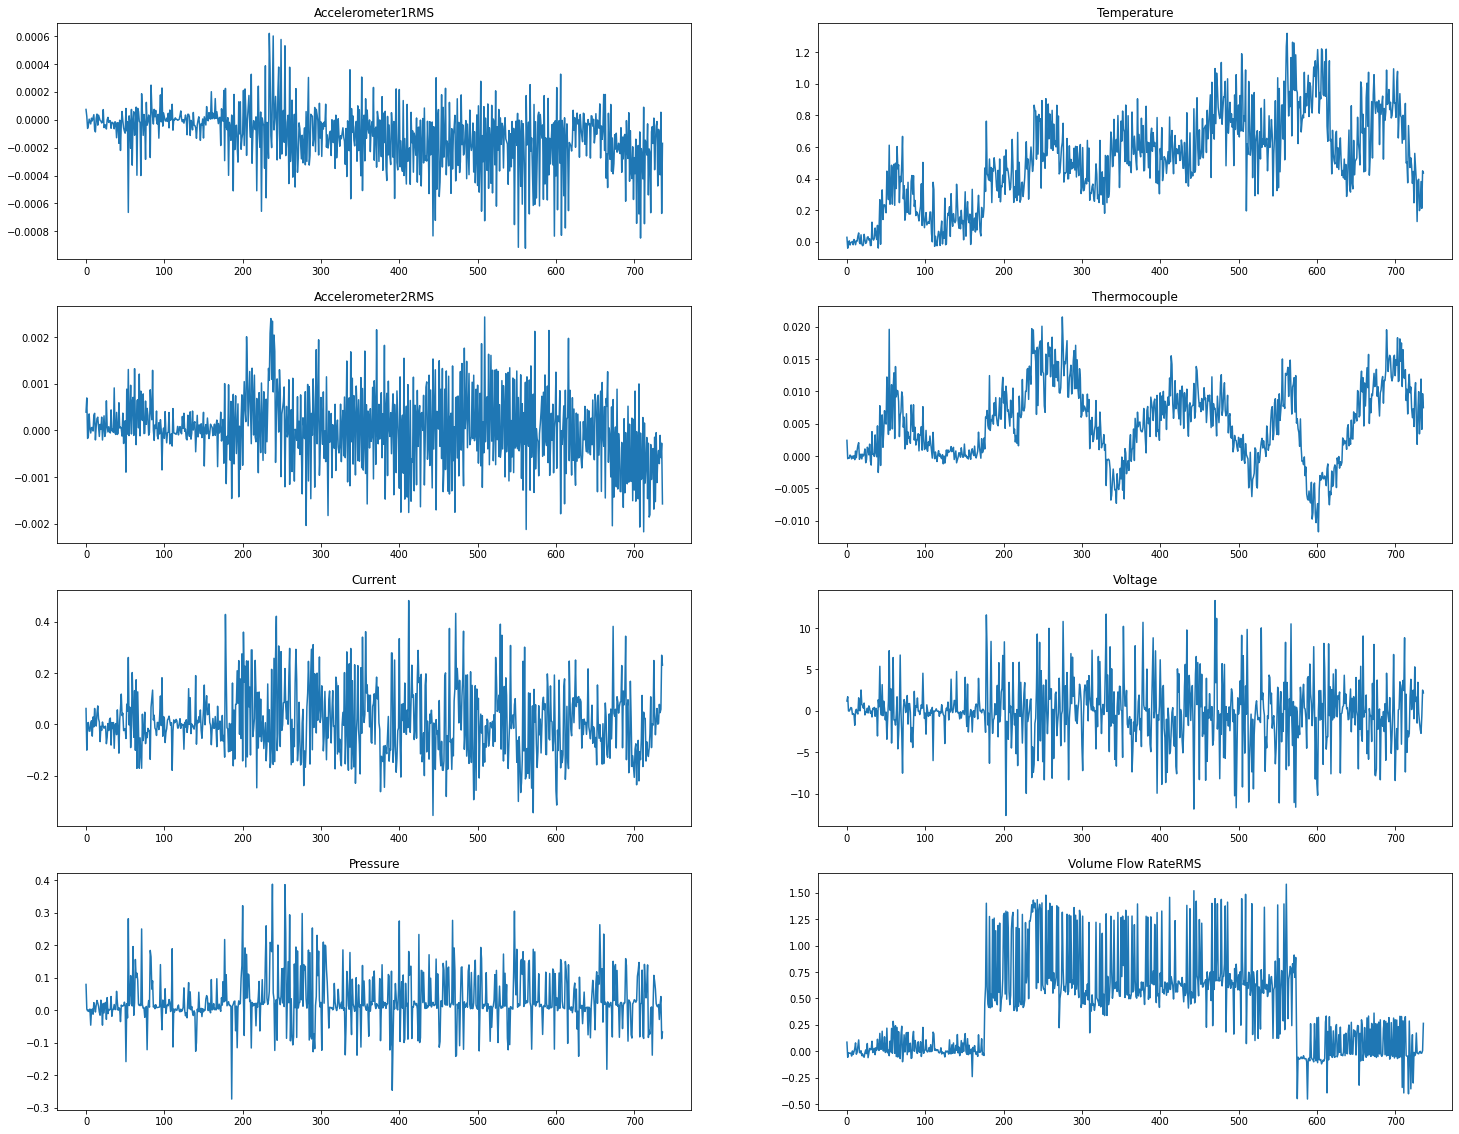

In [325]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(25, 20))

for i in range(rest.shape[0]):
    j = 1 if i >= 4 else 0
    axes[i%4, j].plot(rest[i])
    axes[i%4, j].set_title(df.columns[i])
plt.show()

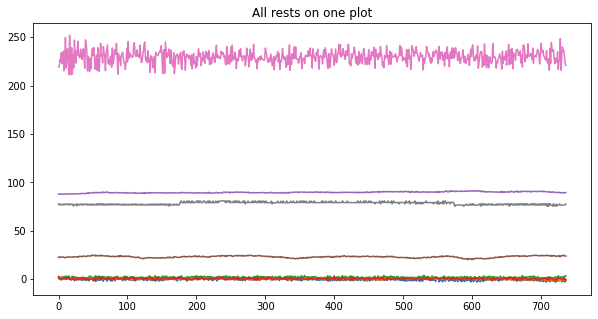

In [280]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("All rests on one plot")
for i in range(rest.shape[0]):   
    ax.plot(rest[i])
plt.show()

### Оценка качества

$$\large MAR = \frac{FN}{TP + FN}$$

$$\large FAR = \frac{FP}{FP + TN}$$

In [24]:
def mar(test, pred):
    fn = ((pred == 0) & (test == 1)).sum()
    tp = ((pred == 1) & (test == 1)).sum()
    return fn / (tp + fn)

def far(test, pred):
    fp = ((pred == 1) & (test == 0)).sum()
    tn = ((pred == 0) & (test == 1)).sum()
    return fp / (fp + tn)